In [7]:
# This is a program to try out machine learning for my small exciplex data set. 
# It's not really big data -- in fact, it's small, expensive data. We have 69 y values, 
# each corresponding to a PAH dimer. 

# We'll also try it with a larger data set of excitation energies for organic molecules 
# Adapted from: https://medium.com/datadriveninvestor/a-practical-guide-to-getting-started-with-machine-learning-3a6fcc0f95aa

# We'll start off trying support vector regression (SVR)

In [43]:
%matplotlib inline
import math 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.utils import shuffle
import numpy as np
import glob
import matplotlib.pyplot as plt

In [20]:
def svr_model(X, y):
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        # grid search for model hyper-parameters 
        param_grid={
        'C': [0.1, 1, 100, 1000],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
    },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    # build model using the pest parameter values found 
    best_svr = SVR(kernel='rbf', C=best_params["C"], 
                   epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)
    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}
    scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    return abs(scores['test_abs_error'].mean()), math.sqrt(abs(scores['test_squared_error'].mean()))

In [21]:
def procData(X, y, printError=True):
    # scale input values 
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    seed = 42
    # shuffle the data 
    X, y = shuffle(X, y, random_state=seed)
    mae, rmse = svr_model(X,y)
    if printError: 
        print("MAE : "+str(mae)+" RMSE : "+str(rmse))
    else: 
        return mae, rmse

In [22]:
fname = 'wnDimers.dat'
datTable = pd.read_table(fname, header=None, delim_whitespace=True, comment='#')

In [23]:
# First, let's just select complex mass and overlap. These are fairly crude measures 
massOverlap = datTable.iloc[:,[3,4]]
emission = datTable.iloc[:,13]
procData(massOverlap, emission)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MAE : 5269.12705217 RMSE : 6514.1794757013295


In [24]:
# Okay, that didn't do so well -- mean absolute error is over 50000 cm^-1. We knew in advance that those 
# weren't the best independent variables to pick. Let's try some different ones. 
# What about both monomer bandgaps? 
bandgaps = datTable.iloc[:,[9,10]]

In [25]:
procData(bandgaps, emission)

MAE : 5404.39404323 RMSE : 6775.797041295864


In [26]:
# even worse! 
bandgapMass = datTable.iloc[:,[9,10,3]]

In [27]:
procData(bandgapMass, emission)

MAE : 5362.49307133 RMSE : 6666.999899386111


In [28]:
bandgapBondLen = datTable.iloc[:,[9,10,26,27]]

In [29]:
procData(bandgapBondLen, emission)

MAE : 5076.1132339 RMSE : 6487.053424379871


In [30]:
planarityBandBond = datTable.iloc[:,[9,10,26,27,5,6]]

In [31]:
procData(planarityBandBond, emission)

MAE : 5650.44777096 RMSE : 6899.570366614819


In [32]:
# just throw the whole thing at it ? 
all = datTable.iloc[:,1:12]

In [33]:
procData(all,emission)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MAE : 5522.31707173 RMSE : 6727.835799930833


In [34]:
bandgapEmit = datTable.iloc[:,9:12]

In [35]:
# No -- we probably don't have enough data to use this method successfully. 
procData(bandgapEmit, emission)

MAE : 5235.49225982 RMSE : 6631.338612779083


In [37]:
path = '/Users/rachelkrueger/Soot/MachineLearning/xyzFiles/'
xyzFiles = glob.glob(path+'*xyz')
for f in xyzFiles: 
    os.system('head -2 '+f+' > '+path+'top'+f)

In [39]:
# What if we try another data set that's larger? 
# There's a large data set of computed info about organic molecules available. 
# It's described in this article: Matthias Rupp, Alexandre Tkatchenko, Klaus-Robert Mueller, O. Anatole von
#  Lilienfeld: Fast and Accurate Modeling of Molecular Atomization Energies with
#  Machine Learning, Physical Review Letters, 108(5): 058301, 2012.
#  DOI: 10.1103/PhysRevLett.108.058301
# The same group computed a bunch of excitation energies at different levels of theory, reported in the publication 
# Electronic Spectra from TDDFT and Machine Learning in Chemical Space",
#  Raghunathan Ramakrishnan, Mia Hartmann, Enrico Tapavicza, O. Anatole von Lilienfeld,
#  J. Chem. Phys. 143, 084111 (2015)
# https://doi.org/10.1063/1.4928757 

# suppose we use HOMO-LUMO gap as an input. How many 
# how many data points do we need to get a good prediction? Let's find out! 
nPointsList = [250, 500, 750, 1000, 1500, 2000]
maeList = list()
rmseList = list()
for n in nPointsList: 
# First, let's read in the excitation energies 
    datFile2='/Users/rachelkrueger/Soot/MachineLearning/gdb8_22k_elec_spec.txt'
    exTable = pd.read_table(datFile2, header=None, delim_whitespace=True, comment='#', nrows=n)
    # Now, the rest of the data is contained in xyz files for the molecules, one molecule data per xyz. 
    # We need to open the appropriate xyz files for the ids listed in the excitation frame. 
    dataLines = list()
    for id in exTable.iloc[:,0]:
        with open(path+str(id)) as dataFile: 
            dataFile.readline()
            tokens = dataFile.readline().split()
            dataLines.append(tokens)
    datArray = np.asarray(dataLines)
    molTable = pd.DataFrame(data=datArray) # ok, we have our data frame 
    mae, rmse = procData(molTable.iloc[:,[8,9]],np.ravel(exTable.iloc[:,[1]].values), False)
    maeList.append(mae)
    rmseList.append(rmse)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  retur

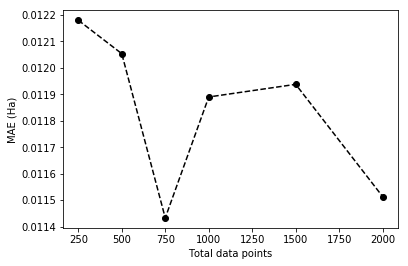

In [46]:
# Now let's plot the RMSE values obtained for each data set size. 
plt.plot(nPointsList, maeList, 'ko--')
plt.xlabel('Total data points')
plt.ylabel('MAE (Ha)')

In [49]:
# Okay, it looks like error is not necessarily converging yet. 
# However, error of 0.0115 Ha = 30 kJ/mol is not bad! It's less than 10% of the excitation energy for most of the 
# molecules in this data set. 

# What if we consider more properties? 
# Let's add isotropic polarizability. 
maeList = list()
rmseList = list()
for n in nPointsList: 
# First, let's read in the excitation energies 
    datFile2='/Users/rachelkrueger/Soot/MachineLearning/gdb8_22k_elec_spec.txt'
    exTable = pd.read_table(datFile2, header=None, delim_whitespace=True, comment='#', nrows=n)
    # Now, the rest of the data is contained in xyz files for the molecules, one molecule data per xyz. 
    # We need to open the appropriate xyz files for the ids listed in the excitation frame. 
    dataLines = list()
    for id in exTable.iloc[:,0]:
        with open(path+str(id)) as dataFile: 
            dataFile.readline()
            tokens = dataFile.readline().split()
            dataLines.append(tokens)
    datArray = np.asarray(dataLines)
    molTable = pd.DataFrame(data=datArray) # ok, we have our data frame 
    mae, rmse = procData(molTable.iloc[:,[7,8,9]],np.ravel(exTable.iloc[:,[1]].values), False)
    maeList.append(mae)
    rmseList.append(rmse)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  retur

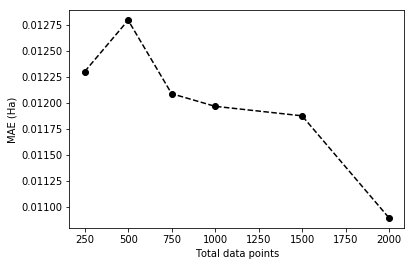

In [50]:
plt.plot(nPointsList, maeList, 'ko--')
plt.xlabel('Total data points')
plt.ylabel('MAE (Ha)')

In [ ]:
# We have reached even lower error -- 28 kJ/mol. However, isotropic polarizability is a pain to calculate. 
# Would it be worth doing for this improvement, if we didn't have the data? Probably not. 